# *Одномерная модель на 1D свёрточных слоях*

В качестве единственного признака используется сама цена.

In [1]:
import os
import glob
import datetime
import pickle

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from pandas_datareader import data as pdr

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
import tensorflow as tf
# tf.test.is_gpu_available()
tf.__version__

'2.0.0'

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (Input, Dense, Convolution1D, MaxPooling1D, Flatten,
                                     ReLU, LeakyReLU, Dropout, BatchNormalization)
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Nadam

In [7]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [8]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [9]:
INSTRUMENT = 'MSFT' # Microsoft corp
START_FROM = np.datetime64('today') - 7
WINDOW_SIZE = 120
FORECAST_OFFSET=1
BATCH_SIZE = 32
FORCE_TRAIN = True

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [10]:
instr = MarketData.create_from_alphavantage_intraday(INSTRUMENT, start=START_FROM)

In [11]:
instr.feature_names

['o',
 'h',
 'l',
 'c',
 'v',
 'ema14',
 'ema30',
 'macd',
 'macd_signal',
 'rsi14',
 'bband20_upper',
 'bband20_middle',
 'bband20_lower',
 'willr14',
 'stochk',
 'stochd',
 'adline',
 'adosc']

Здесь не будем делить отдельно на тест и валидацию, поскольку данных у нас только 5 дней.

In [12]:
dates_unique = np.unique(instr.timestamps.astype('datetime64[D]'))

START_FROM = dates_unique[0]
VAL_TEST_SPLIT = dates_unique[-1]

START_FROM, VAL_TEST_SPLIT

(numpy.datetime64('2020-04-09'), numpy.datetime64('2020-04-15'))

## Целевая переменная

Цена закрытия.

In [13]:
orig_target = instr.c

Переходим к логарифмической доходности.

In [14]:
transformed_target = instr.c.transform(transforms={'ratios' : {}, 'ln' : {}})

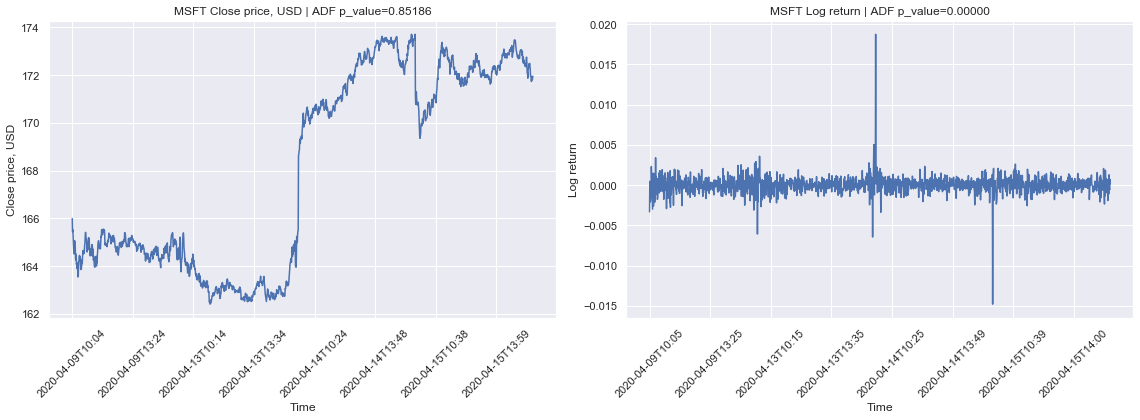

In [15]:
plotHelpers.plot_transformed_timeseries_unit(instr,
                                             transformed_target,
                                             'Close price, USD', 'Log return',
                                             datetime_unit='m', rotation=45)

## Трансформация признаков

Из признаков выбираем только цену закрытия. Временной ряд цен преобразуется к ряду логарифмических доходностей (что также позволяет убрать нестационарность).

In [16]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'c': price_transformer(),
    }
    return feature_transformations

In [17]:
instr_transformed = instr.select_transform(make_feature_selector())

In [18]:
transformed_target = instr_transformed.c

## Обучающая, валидационная и тестовая выборки

In [19]:
instr_train, instr_test = instr_transformed.train_test_split(VAL_TEST_SPLIT, window_size=WINDOW_SIZE,
                                                             scaler=StandardScaler)
#                                                              scaler=MinMaxScaler,
#                                                              scaler_kwargs={'feature_range': (-1, 1)})

# instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_test)

(1132, 509)

## Признаки - скользящие окна

In [20]:
train_mwf = MovingWindowFeatures.create(instr_train.c, [instr_train], instr_train.feature_names, window_size=WINDOW_SIZE)
# val_mwf = MovingWindowFeatures.create(instr_val.c, [instr_val], instr_val.feature_names, window_size=WINDOW_SIZE)
test_mwf = MovingWindowFeatures.create(instr_test.c, [instr_test], instr_test.feature_names, window_size=WINDOW_SIZE)

len(instr_train), len(train_mwf), train_mwf.features.shape

(1132, 1012, (1012, 120, 1))

Проверка, что скользящие окна соответствуют исходным данным.

Возьмём произвольный признак и произвольное окно (строка #**41**). Проверим, что данные в точности совпадают:

In [21]:
def check_data(md, mwf, row):
    col = np.random.randint(len(mwf.feature_names))
    feature = mwf.feature_names[col]
    check = (getattr(md, feature).data[row:row + mwf.window_size] == mwf.features[row, :, col]).all()
    assert check
    return feature, check

check_data(instr_train, train_mwf, 41)

('c', True)

# *Модели*

Модель с двумя 1D свёрточными слоями.

In [22]:
def build_conv1d_layers(input_shape, filters=(32, 16, 8), kernel_size=3, pool_size=2):
    # формат входа: наша матрица (окно; признак)
    inp = Input(input_shape, name='input')

    filter_blocks = np.array(filters)
    filter_blocks = np.lib.stride_tricks.as_strided(filter_blocks, 
                                                    (filter_blocks.shape[0] - 1, 2), 
                                                    2 * [filter_blocks.strides[0]])
    conv1d = inp
    # стекаем слои Conv1D: блоками Conv1D-Conv1D-MaxPool
    for filter_block in filter_blocks:
        for f in filter_block:
            conv1d = Convolution1D(filters=f,
                                   kernel_size=kernel_size,
                                   padding='same',
                                   bias_initializer='he_uniform',
                                   bias_regularizer=L1L2(0.01, 0.02),
                                   kernel_regularizer=L1L2(0.01, 0.02)
                                  )(conv1d)
            conv1d = BatchNormalization()(conv1d)
            conv1d = LeakyReLU()(conv1d)
            conv1d = Dropout(0.25)(conv1d)
        conv1d = MaxPooling1D(pool_size=pool_size)(conv1d)
    
    conv1d = Flatten()(conv1d)
    
    return inp, conv1d

#### Пути сохранения моделей:

In [23]:
model_path_root = 'models'
model_type_name = 'conv1d_univar'

def make_model_save_dir(path_root, type_name, class_name):
    save_dir = os.path.join(path_root, type_name, class_name)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

#### Общие коллбэки:

In [24]:
# уменьшение learning rate в случае, если loss не изменяется
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# уменьшение learning rate в 2 раза каждую 5-ю эпоху
def lr_decay(e, lr):
    return lr * (1 - 0.5 * (0 == (e + 1) % 5))

lr_scheduler = LearningRateScheduler(schedule=lr_decay, verbose=1)

## Задача регрессии

Непосредственное прогнозирование цены следующего периода.

In [25]:
train_regr_gen = RegressionGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_regr_gen = RegressionGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_regr_gen = RegressionGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

Следующие числа соответствуют значению параметра `steps_per_epoch` метода [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0") - то есть это число батчей, которые генератор выдаст за одну эпоху обучения (если класс генератора поддерживает метод `len()`, то данный параметр можно не указывать).

In [26]:
len(train_regr_gen), len(test_regr_gen)

(32, 13)

Один сэмпл данных представляет собой матрицу размером *(длина окна; число признаков)*

In [27]:
train_regr_gen.input_shape

(120, 1)

### Модель для задачи регрессии

In [28]:
model_class_name = 'regression'

In [29]:
def build_regression_model(input_shape):
    inp, conv1d = build_conv1d_layers(input_shape, filters=(32, 16, 8))

    regr = Dense(64)(conv1d)
    regr = BatchNormalization()(regr)
    regr = LeakyReLU()(regr)
    regr = Dropout(0.25)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    return Model(inputs=[inp], outputs=[regr])

In [30]:
univariate_regression_conv1d = build_regression_model(train_regr_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:
[`Nadam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) (*Adam with Nestrov momentum*).

In [31]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Дополнительные коллбэки:

In [32]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Функция потерь:

В качестве функции потерь будем использовать [MSE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE) (чтобы штрафовать за большие отклонения). Xотя хорошая функция потерь в контексте темы данной задачи - это [вопрос сложный](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb). В частности, здесь нам, очевидно, помимо абсолютного значения отклонения также важен его знак.

In [33]:
univariate_regression_conv1d.compile(optimizer=optimizer,
                                   loss={'regr': 'mse'},
                                   metrics={'regr': 'mae'})

univariate_regression_conv1d.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 120, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 120, 32)           128       
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 32)           128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 120, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 120, 16)           1552      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 16)           64    

#### Обучение:

In [34]:
regr_history = utils.train_model(univariate_regression_conv1d,
                                 model_save_dir, train_regr_gen, test_regr_gen,
                                 callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                 force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
31/32 [============================>.] - ETA: 0s - loss: 6.4259 - mae: 0.9473
Epoch 00001: val_loss improved from inf to 5.53601, saving model to models\conv1d_univar\regression\01.hdf5
32/32 [==============================] - 10s 311ms/step - loss: 6.4023 - mae: 0.9446 - val_loss: 5.5360 - val_mae: 0.6746

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
31/32 [============================>.] - ETA: 0s - loss: 5.8330 - mae: 0.8409
Epoch 00002: val_loss improved from 5.53601 to 5.37115, saving model to models\conv1d_univar\regression\02.hdf5
32/32 [==============================] - 5s 164ms/step - loss: 5.8174 - mae: 0.8398 - val_loss: 5.3712 - val_mae: 0.6717

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
31/32 [============================>.] - ETA: 0s - loss: 5.5587 - mae: 0.8100
Epoch 00003: va

31/32 [============================>.] - ETA: 0s - loss: 4.1541 - mae: 0.7061
Epoch 00021: val_loss improved from 4.29337 to 4.28273, saving model to models\conv1d_univar\regression\21.hdf5
32/32 [==============================] - 5s 156ms/step - loss: 4.1377 - mae: 0.7037 - val_loss: 4.2827 - val_mae: 0.7025

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
31/32 [============================>.] - ETA: 0s - loss: 4.2590 - mae: 0.7147
Epoch 00022: val_loss improved from 4.28273 to 4.26953, saving model to models\conv1d_univar\regression\22.hdf5
32/32 [==============================] - 5s 155ms/step - loss: 4.2518 - mae: 0.7135 - val_loss: 4.2695 - val_mae: 0.7017

Epoch 00023: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 23/32
31/32 [============================>.] - ETA: 0s - loss: 4.1531 - mae: 0.6895
Epoch 00023: val_loss improved from 4.26953 to 4.25914, saving model to models\conv1d_univar\regression\23.h

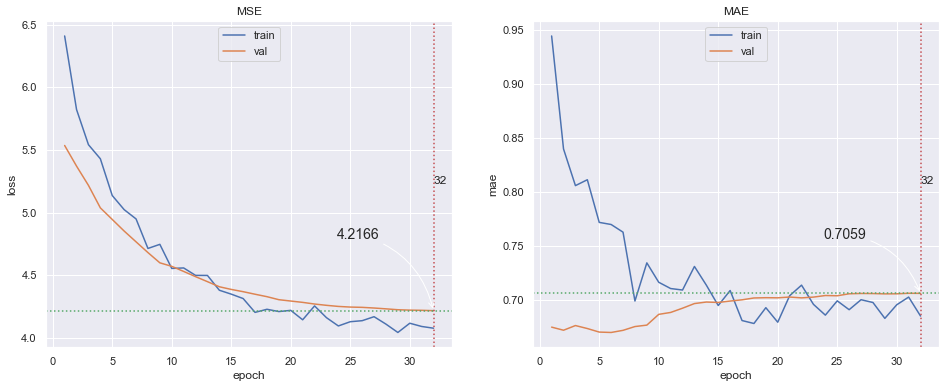

In [35]:
def plot_regr_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'MSE', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'MAE', 'mae', 'val_mae')
    
plot_regr_history(regr_history);

### Прогноз задачи регрессии

In [36]:
# загружаем последнюю эпоху с минимальным лоссом
univariate_regression_conv1d.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [37]:
pred_log_ret_test = univariate_regression_conv1d.predict_generator(test_regr_gen, verbose=1)

13/13 [==============================] - 0s 30ms/step


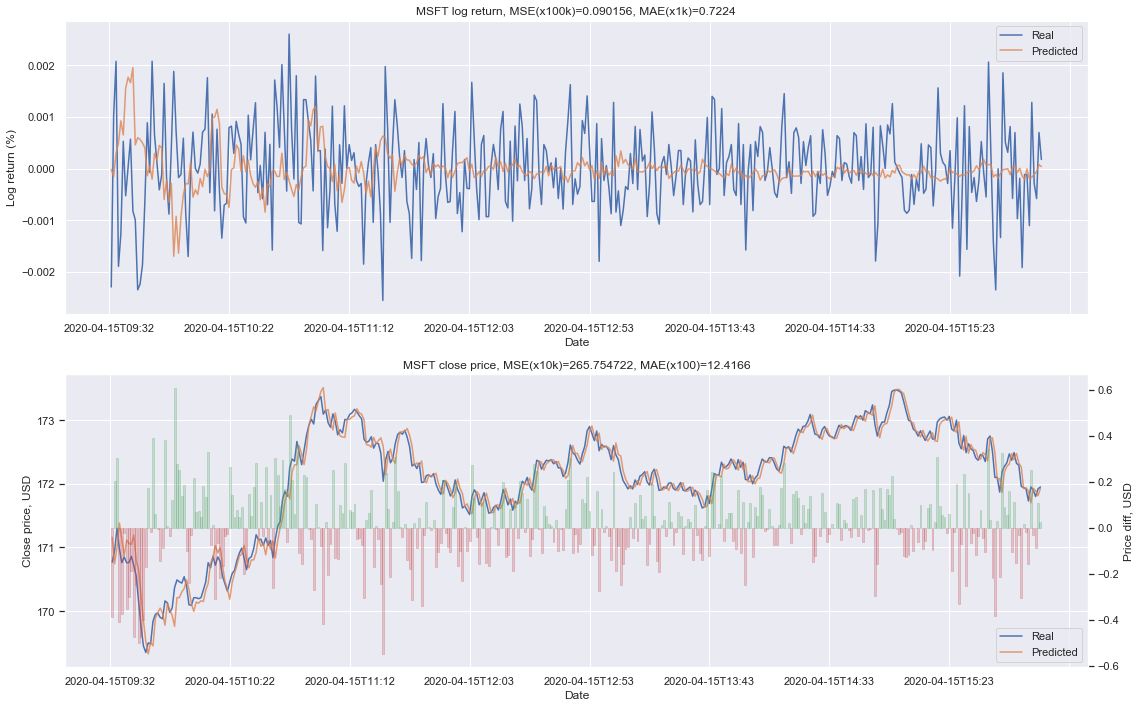

In [38]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 10),
                                  datetime_unit='m', plot_data_slice=slice(1, None))

## Задача классификации

Прогнозируем направление изменения цены по сравнению с предыдущим периодом (**0** - снижение, **1** - рост).

In [39]:
model_class_name = 'classification'

In [40]:
train_clf_gen = ClassificationGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_clf_gen = ClassificationGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_clf_gen = ClassificationGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
def build_classification_model(input_shape):
    inp, conv1d = build_conv1d_layers(input_shape, filters=(32, 16, 8))

    clf = Dense(64)(conv1d)
    clf = BatchNormalization()(clf)
    clf = LeakyReLU()(clf)
    clf = Dropout(0.25)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)

    return Model(inputs=[inp], outputs=[clf])

In [42]:
univariate_classification_conv1d = build_classification_model(test_clf_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [43]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [44]:
univariate_classification_conv1d.compile(optimizer=optimizer,
                                         loss={'clf': 'binary_crossentropy'},
                                         metrics={'clf': 'accuracy'})

univariate_classification_conv1d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 120, 1)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 120, 32)           128       
_________________________________________________________________
batch_normalization_5 (Batch (None, 120, 32)           128       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 120, 32)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 120, 16)           1552      
_________________________________________________________________
batch_normalization_6 (Batch (None, 120, 16)           64  

#### Дополнительные коллбэки:

In [45]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [46]:
clf_history = utils.train_model(univariate_classification_conv1d,
                                model_save_dir, train_clf_gen, test_clf_gen,
                                callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
31/32 [============================>.] - ETA: 0s - loss: 5.0951 - accuracy: 0.4970
Epoch 00001: val_loss improved from inf to 4.71653, saving model to models\conv1d_univar\classification\01.hdf5
32/32 [==============================] - 7s 205ms/step - loss: 5.0811 - accuracy: 0.4990 - val_loss: 4.7165 - val_accuracy: 0.5219

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
31/32 [============================>.] - ETA: 0s - loss: 4.4991 - accuracy: 0.5312
Epoch 00002: val_loss improved from 4.71653 to 4.14993, saving model to models\conv1d_univar\classification\02.hdf5
32/32 [==============================] - 5s 169ms/step - loss: 4.4976 - accuracy: 0.5247 - val_loss: 4.1499 - val_accuracy: 0.5476

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
31/32 [============================>.] - ETA: 0s - loss:

31/32 [============================>.] - ETA: 0s - loss: 1.8229 - accuracy: 0.5060
Epoch 00020: val_loss improved from 1.80814 to 1.79406, saving model to models\conv1d_univar\classification\20.hdf5
32/32 [==============================] - 5s 157ms/step - loss: 1.8215 - accuracy: 0.5079 - val_loss: 1.7941 - val_accuracy: 0.5501

Epoch 00021: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 21/32
31/32 [============================>.] - ETA: 0s - loss: 1.7944 - accuracy: 0.5393
Epoch 00021: val_loss improved from 1.79406 to 1.77949, saving model to models\conv1d_univar\classification\21.hdf5
32/32 [==============================] - 5s 159ms/step - loss: 1.7904 - accuracy: 0.5455 - val_loss: 1.7795 - val_accuracy: 0.5501

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
31/32 [============================>.] - ETA: 0s - loss: 1.7900 - accuracy: 0.5323
Epoch 00022: val_loss improved from 1.77949 to 1.76495, saving mo

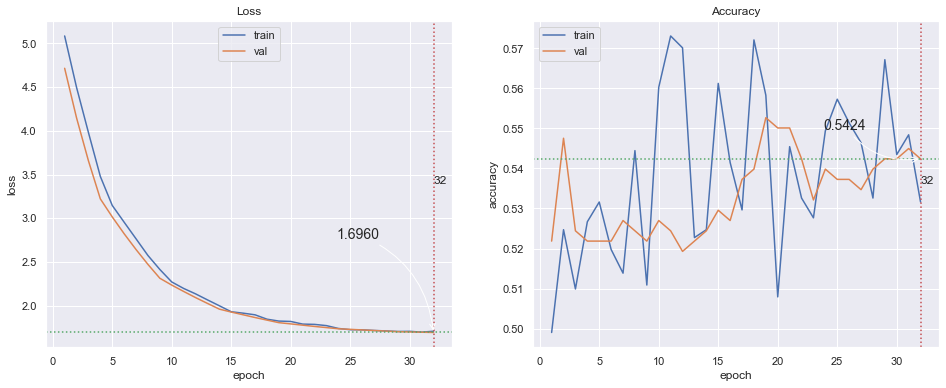

In [47]:
def plot_clf_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'Loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'Accuracy', 'accuracy', 'val_accuracy')
    
plot_clf_history(clf_history);

### Прогноз задачи классификации

In [48]:
# загружаем последнюю эпоху с минимальным лоссом
univariate_classification_conv1d.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

In [49]:
pred_direction_proba = univariate_classification_conv1d.predict_generator(test_clf_gen, verbose=1)

true_direction = test_clf_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

13/13 [==============================] - 0s 23ms/step


0.4832678

In [50]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([203, 186], dtype=int64)),
 (array([0, 1]), array([211, 178], dtype=int64)))

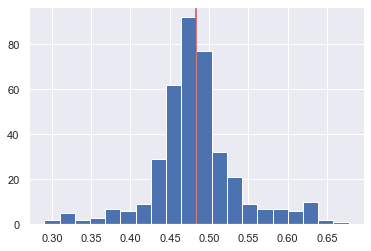

In [51]:
plt.hist(pred_direction_proba, bins=20)
plt.axvline(np.mean(pred_direction_proba), c='r');

In [52]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       203
           1       0.49      0.47      0.48       186

    accuracy                           0.52       389
   macro avg       0.51      0.51      0.51       389
weighted avg       0.52      0.52      0.52       389



In [53]:
confusion_matrix(true_direction, predicted_direction)

array([[113,  90],
       [ 98,  88]], dtype=int64)

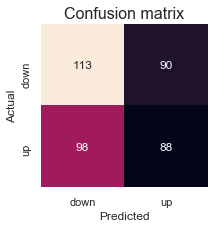

array([[0.53554502, 0.50561798],
       [0.46445498, 0.49438202]])

In [54]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

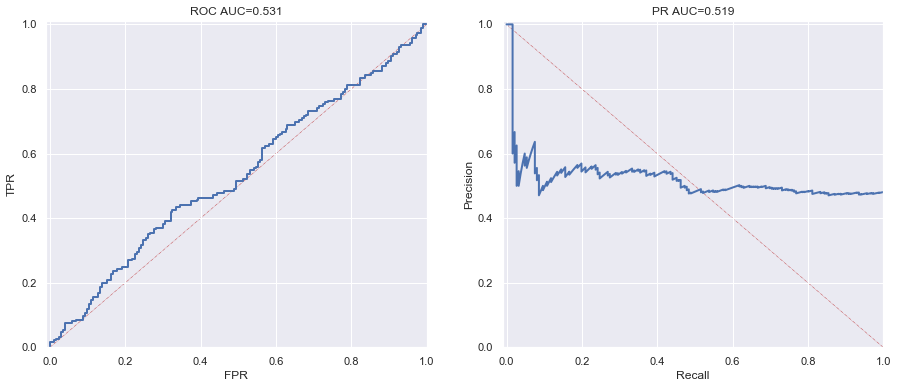

In [55]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

## Многозадачная модель: одновременно регрессия и классификация

In [56]:
model_class_name = 'multitask'

In [57]:
train_multi_gen = MultitaskGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_multi_gen = MultitaskGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_multi_gen = MultitaskGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [58]:
def build_multitask_model(input_shape):
    inp, conv1d = build_conv1d_layers(input_shape, filters=(32, 16, 8))

    # первый выход: задача регрссии
    regr = Dense(64)(conv1d)
    regr = BatchNormalization()(regr)
    regr = LeakyReLU()(regr)
    regr = Dropout(0.25)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    # второй выход: задача классификации
    clf = Dense(64)(conv1d)
    clf = BatchNormalization()(clf)
    clf = LeakyReLU()(clf)
    clf = Dropout(0.25)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)
    
    return Model(inputs=[inp], outputs=[regr, clf])

In [59]:
univariate_multitask_conv1d = build_multitask_model(train_multi_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [60]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [61]:
univariate_multitask_conv1d.compile(optimizer=optimizer,
                                    loss={'regr': 'mse', 'clf': 'binary_crossentropy'},
                                    loss_weights={'regr': 1., 'clf': 1.},
                                    metrics={'regr': 'mae', 'clf' : 'accuracy'})

univariate_multitask_conv1d.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 120, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 120, 32)      128         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 120, 32)      128         conv1d_8[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 120, 32)      0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

#### Дополнительные коллбэки:

In [62]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [63]:
multitask_history = utils.train_model(univariate_multitask_conv1d,
                                      model_save_dir, train_multi_gen, test_multi_gen,
                                      callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                      force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
31/32 [============================>.] - ETA: 0s - loss: 7.3767 - regr_loss: 2.0653 - clf_loss: 0.7824 - regr_mae: 0.9848 - clf_accuracy: 0.5020
Epoch 00001: val_loss improved from inf to 6.26928, saving model to models\conv1d_univar\multitask\01.hdf5
32/32 [==============================] - 7s 208ms/step - loss: 7.3643 - regr_loss: 2.0533 - clf_loss: 0.7839 - regr_mae: 0.9862 - clf_accuracy: 0.5010 - val_loss: 6.2693 - val_regr_loss: 1.1083 - val_clf_loss: 0.7027 - val_regr_mae: 0.6773 - val_clf_accuracy: 0.4499

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
31/32 [============================>.] - ETA: 0s - loss: 6.7390 - regr_loss: 1.5938 - clf_loss: 0.7566 - regr_mae: 0.8655 - clf_accuracy: 0.5101 ETA: 5s - loss: 6.7663 - regr_loss: 1.6034 - 
Epoch 00002: val_loss improved from 6.26928 to 6.08726, saving model to models\conv1d_univar\multi

31/32 [============================>.] - ETA: 0s - loss: 5.1825 - regr_loss: 1.1125 - clf_loss: 0.6999 - regr_mae: 0.6939 - clf_accuracy: 0.5252
Epoch 00014: val_loss improved from 5.22682 to 5.18131, saving model to models\conv1d_univar\multitask\14.hdf5
32/32 [==============================] - 6s 202ms/step - loss: 5.1752 - regr_loss: 1.1056 - clf_loss: 0.7001 - regr_mae: 0.6941 - clf_accuracy: 0.5267 - val_loss: 5.1813 - val_regr_loss: 1.1362 - val_clf_loss: 0.6991 - val_regr_mae: 0.6766 - val_clf_accuracy: 0.4961

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0001250000059371814.
Epoch 15/32
31/32 [============================>.] - ETA: 0s - loss: 5.2047 - regr_loss: 1.1709 - clf_loss: 0.6986 - regr_mae: 0.7160 - clf_accuracy: 0.5292
Epoch 00015: val_loss improved from 5.18131 to 5.15815, saving model to models\conv1d_univar\multitask\15.hdf5
32/32 [==============================] - 6s 198ms/step - loss: 5.2127 - regr_loss: 1.1816 - clf_loss: 0.6963 - regr_mae: 0.7

31/32 [============================>.] - ETA: 0s - loss: 4.8915 - regr_loss: 1.0437 - clf_loss: 0.6936 - regr_mae: 0.6474 - clf_accuracy: 0.5433
Epoch 00027: val_loss improved from 5.00018 to 4.99559, saving model to models\conv1d_univar\multitask\27.hdf5
32/32 [==============================] - 7s 203ms/step - loss: 4.8765 - regr_loss: 1.0262 - clf_loss: 0.6960 - regr_mae: 0.6458 - clf_accuracy: 0.5435 - val_loss: 4.9956 - val_regr_loss: 1.1444 - val_clf_loss: 0.7003 - val_regr_mae: 0.6780 - val_clf_accuracy: 0.5141

Epoch 00028: LearningRateScheduler reducing learning rate to 3.125000148429535e-05.
Epoch 28/32
31/32 [============================>.] - ETA: 0s - loss: 4.8994 - regr_loss: 1.0569 - clf_loss: 0.6946 - regr_mae: 0.6765 - clf_accuracy: 0.5393
Epoch 00028: val_loss improved from 4.99559 to 4.99040, saving model to models\conv1d_univar\multitask\28.hdf5
32/32 [==============================] - 7s 210ms/step - loss: 4.8936 - regr_loss: 1.0524 - clf_loss: 0.6933 - regr_mae: 0.6

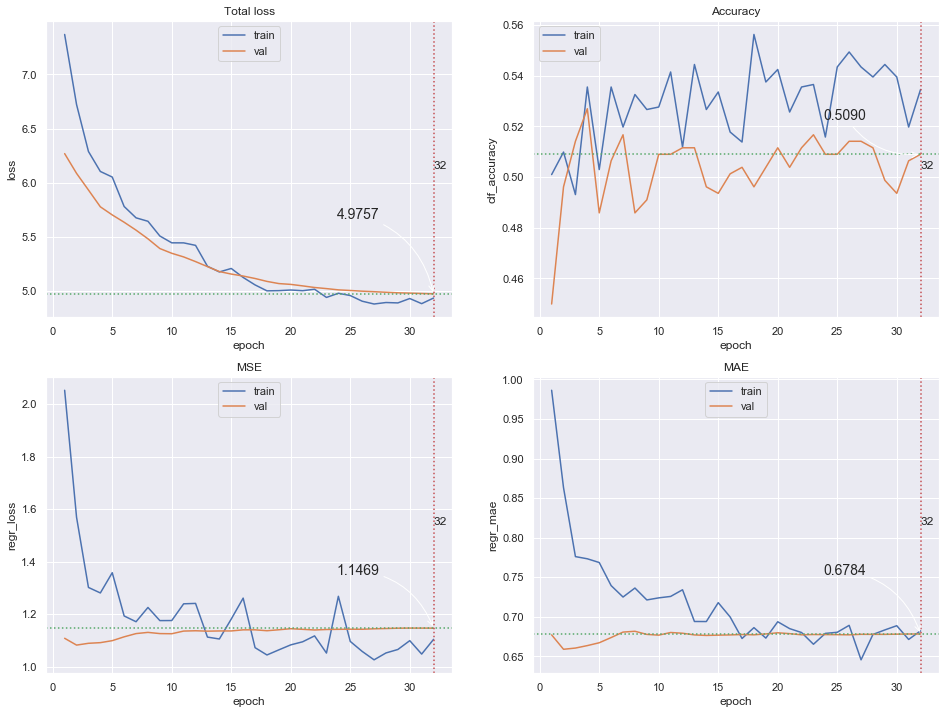

In [64]:
def plot_multitask_history(hist):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    plotHelpers.plot_train_history(ax[0, 0], hist, 'Total loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[0, 1], hist, 'Accuracy', 'clf_accuracy', 'val_clf_accuracy')
    plotHelpers.plot_train_history(ax[1, 0], hist, 'MSE', 'regr_loss', 'val_regr_loss')
    plotHelpers.plot_train_history(ax[1, 1], hist, 'MAE', 'regr_mae', 'val_regr_mae')
    
plot_multitask_history(multitask_history);

### Прогноз

In [65]:
# загружаем последнюю эпоху с минимальным лоссом
univariate_multitask_conv1d.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [66]:
pred_log_ret, pred_direction_proba = univariate_multitask_conv1d.predict_generator(test_multi_gen, verbose=1)

13/13 [==============================] - 0s 28ms/step


In [67]:
np.set_printoptions(precision=3, suppress=True)

np.column_stack([pred_log_ret, pred_direction_proba])[-10:]

array([[-0.005,  0.498],
       [ 0.046,  0.473],
       [ 0.031,  0.503],
       [-0.024,  0.447],
       [ 0.003,  0.482],
       [-0.187,  0.463],
       [-0.133,  0.47 ],
       [-0.052,  0.488],
       [ 0.023,  0.501],
       [ 0.079,  0.489]], dtype=float32)

#### Прогноз задачи регрессии

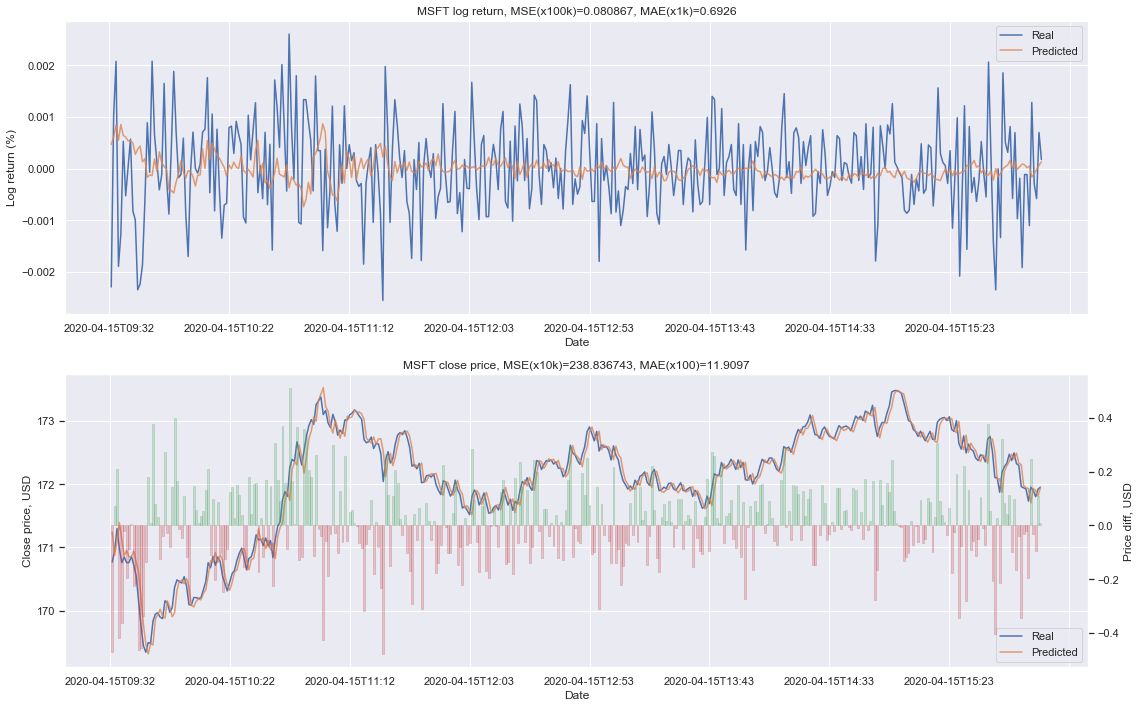

In [68]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret, figsize=(16, 10),
                                  datetime_unit='m', plot_data_slice=slice(1, None))

#### Прогноз задачи классификации

In [69]:
true_direction = test_clf_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

0.49645203

In [70]:
true_direction = test_multi_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

In [71]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([203, 186], dtype=int64)),
 (array([0, 1]), array([204, 185], dtype=int64)))

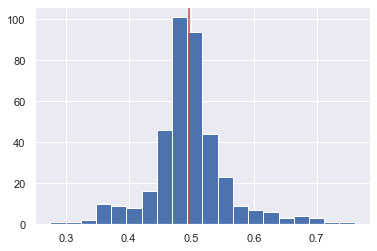

In [72]:
plt.hist(pred_direction_proba, bins=20)
plt.axvline(np.mean(pred_direction_proba), c='r');

In [73]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       203
           1       0.46      0.46      0.46       186

    accuracy                           0.49       389
   macro avg       0.49      0.49      0.49       389
weighted avg       0.49      0.49      0.49       389



In [74]:
confusion_matrix(true_direction, predicted_direction)

array([[104,  99],
       [100,  86]], dtype=int64)

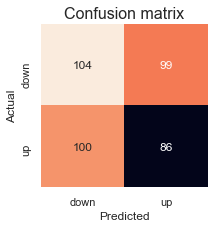

array([[0.51 , 0.535],
       [0.49 , 0.465]])

In [75]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

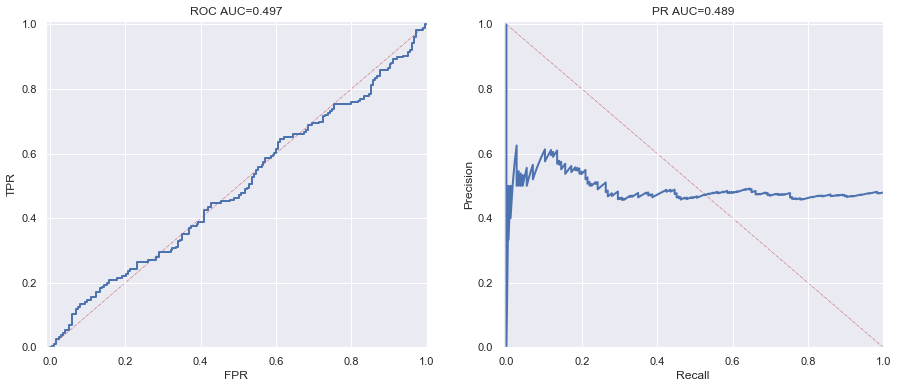

In [76]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

# Выводы

1.  Модель с 1D свёртками обучается гораздо быстрее модели LSTM
2.  Задача классификации не решается удовлетворительно.